In [1]:
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

In [2]:
# Note: gym changed from version 0.7.3 to 0.8.0
# MointainCar episode lenght is capped at 200 in later versions.
# This means your agent can't learn as much in the aerleier episodes
# since they are no longer as long.

# Adapt Q-Learning script to use N-setp method instead

import gym
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from gym import wrappers
from datetime import datetime

# code we alredy wrote
import q_learning
from q_learning import plot_cost_to_go, FeatureTransformer, Model, plot_running_avg

In [3]:
class SGDRegressor:
    def __init__(self, **kwargs):
        self.w = None
        self.lr = 10e-3
        
    def partial_fit(self, X, Y):
        if self.w is None:
            D = X.shape[1]
            self.w = np.random.randn(D) / np.sqrt(D)
        self.w += self.lr * (Y - X.dot(self.w)).dot(X)
        
    def predict(self, X):
        return X.dot(self.w)

In [4]:
# replace SKLearn Regressor
q_learning.SGDRegressor = SGDRegressor


In [7]:
def play_one(model, eps, gamma, n=5):
    observation = env.reset()
    done = False
    totalreward = 0
    rewards = []
    states = []
    actions = []
    iters = 0
    # array of [gamma^0, gamma^1, ..., gamma^(n-1)]
    multiplier = np.array([gamma]*n)**np.arange(n)
    # while not done an iters < 200:
    while not done and iters < 10000:
        # in earlier versions of gym, episode doesn't automatically
        # end when you hit 200 steps
        action = model.sample_action(observation, eps)
        
        states.append(observation)
        actions.append(action)
        
        prev_observation = observation
        observation, reward, done, info = env.step(action)
        
        rewards.append(reward)
        
        # update the model
        if len(rewards) >= n:
            return_up_to_prediction = multiplier.dot(rewards[-n:])
            G = return_up_to_prediction + (gamma ** n) * np.max(model.predict(observation)[0])
            model.update(states[-n], actions[-n], G)
        
        totalreward += reward
        iters += 1
    
    # empty the cache
    rewards = rewards[-n+1:]
    states = states[-n+1:]
    actions = actions[-n+1:]
    
    # unfortunately, new version of gym cuts you off at 200 steps
    # even if you haven't reached the goal.
    # it's not good to do this UNLESS you've reached the goal.
    # we are "really done" if position >= 0.5
    if observation[0] >= 0.5:
        # we actually made it to the goal
        # print("made it!)
        while len(rewards) > 0:
            G = multiplier[:len(rewards)].dot(rewards)
            model.update(states[0], actions[0], G)
            rewards.pop(0)
            states.pop(0)
            actions.pop(0)
    else:
        # we did not make it to the goal
        # print("didn't make it...")
        while len(rewards) > 0:
            guess_rewards = rewards + [-1]*(n - len(rewards))
            G = multiplier.dot(guess_rewards)
            model.update(states[0], actions[0], G)
            rewards.pop(0)
            states.pop(0)
            actions.pop(0)
    
    
    return totalreward
        

episode: 0 total reward: -200.0
episode: 100 total reward: -149.0
episode: 200 total reward: -144.0
avg reward for last 100 episodes: -135.25
total steps: 43196.0


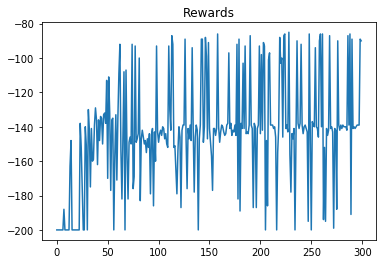

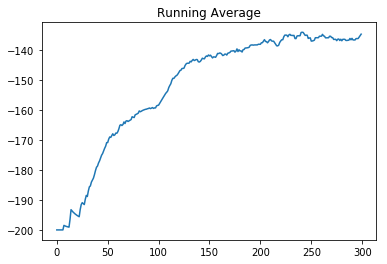

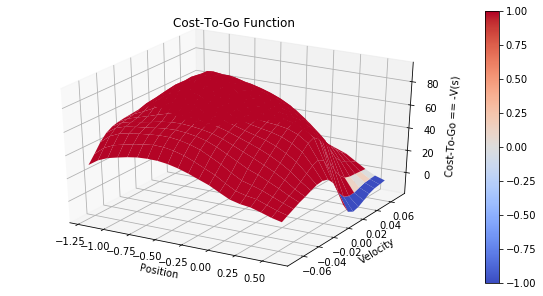

In [8]:
if __name__ == '__main__':
    env = gym.make('MountainCar-v0')
    ft = FeatureTransformer(env)
    model = Model(env, ft, "constant")
    gamma = 0.99
    
    if 'monitor' in sys.argv:
        filename = os.path.basename(__file__).split('.')[0]
        monitor_dir = './' + filename + '_' + str(datetime.now())
        env = wrappers.Monitor(env, monitor_dir)
        
    N = 300
    totalrewards = np.empty(N)
    costs = np.empty(N)
    for n in range(N):
        # eps = 1.0/(0.1*n+1)
        eps = 0.1*(0.97**n)
        totalreward = play_one(model, eps, gamma)
        totalrewards[n] = totalreward
        if n % 100 == 0:
            print("episode:", n, "total reward:", totalreward)
    print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
    print("total steps:", -totalrewards.sum())
    
    plt.plot(totalrewards)
    plt.title("Rewards")
    plt.show()
    
    plot_running_avg(totalrewards)
    
    # plot the optimal state-value function
    plot_cost_to_go(env, model)